In [370]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import shap

In [371]:
data = pd.read_csv('data.csv')

In [372]:
data.set_index('OSEBuildingID', inplace = True)

In [373]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [374]:
cols = ['Age','PropertyGFATotal',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


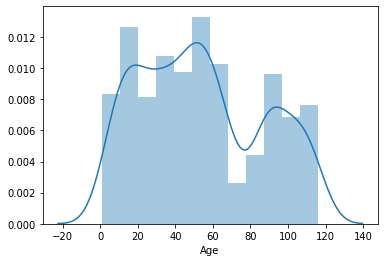

PropertyGFATotal
19.037917545145827


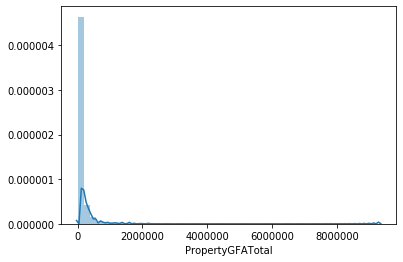

SiteEUI(kBtu/sf)
3.767000453173848


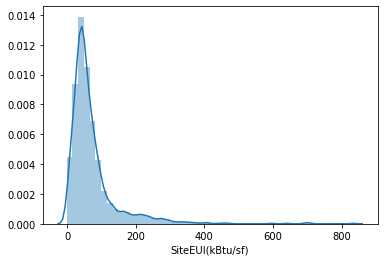

SiteEUIWN(kBtu/sf)
3.6664593768907086


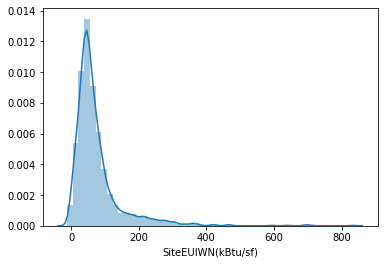

SourceEUI(kBtu/sf)
5.02139873400849


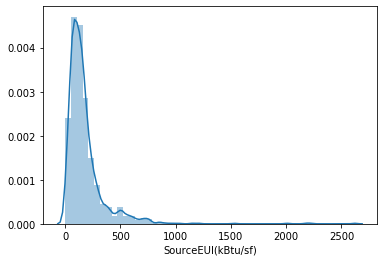

SourceEUIWN(kBtu/sf)
4.998804175082916


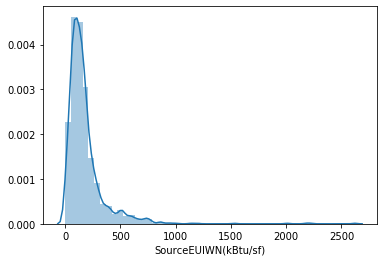

SiteEnergyUse(kBtu)
17.973308078803022


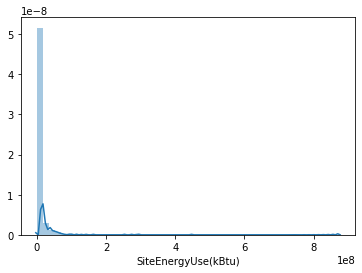

SiteEnergyUseWN(kBtu)
11.273463145790341


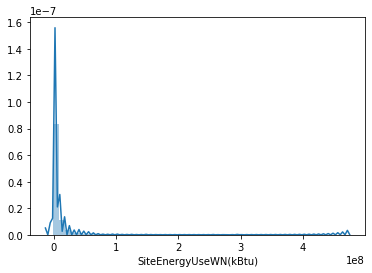

LargestPropertyUseTypeGFA
23.175161728669494


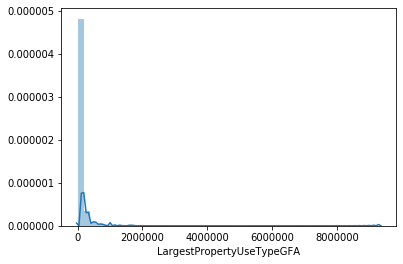

ENERGYSTARScore
0.07727154779048637


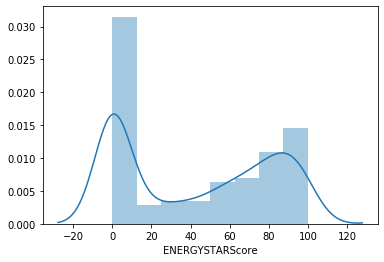

TotalGHGEmissions
14.130616835139792


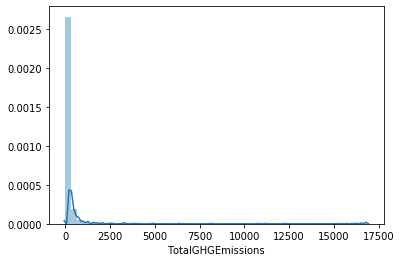

In [375]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

In [378]:
cols = ['Age','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','PropertyGFATotal',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

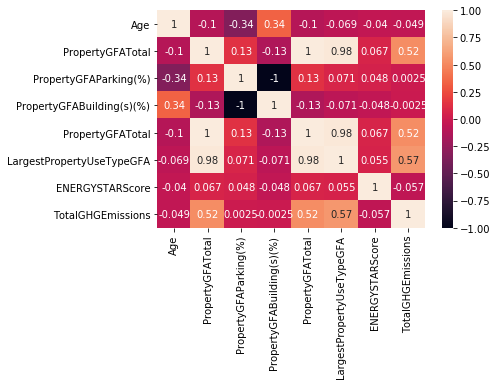

In [379]:
sns.heatmap(data[cols].corr(), annot = True)

In [380]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [381]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [382]:
colsk = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [383]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
X_train_tt = std_scale.transform(X_train_tt)
X_test_tt = std_scale.transform(X_test_tt)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [384]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

770.5687305972889

In [385]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

614.7720113903748

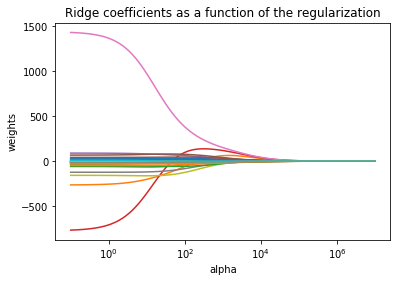

In [386]:
n_alphas = 100
alphas = np.logspace(-1, 7, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

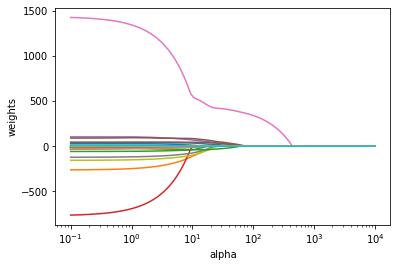

In [387]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [388]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_test_RMSE', 'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [389]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [390]:
params = {'alpha': np.logspace(0, 7, 20)}
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
8,{'alpha': 885.8667904100823},476.639195,1,391733.232026,1,158.033462,1,0.174566,2
7,{'alpha': 379.26901907322497},499.014277,2,399812.073361,2,166.462100,2,0.098645,4
9,{'alpha': 2069.138081114788},516.894437,3,430045.350869,3,167.498079,3,0.175937,1
10,{'alpha': 4832.930238571752},554.135987,4,478036.314766,4,181.645970,4,0.121211,3
6,{'alpha': 162.3776739188721},558.543953,5,487951.291381,5,183.185330,5,-0.068267,7


In [391]:
grid_ridge_best_params = {'alpha': 885.8667904100823}	

In [392]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

672.8791568764291

In [393]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
22,{'alpha': 108.2636733874054},482.539769,1,390921.906220,2,166.906055,3,0.155596,1
21,{'alpha': 78.80462815669912},488.342255,2,390012.762722,1,165.871353,2,0.137284,3
20,{'alpha': 57.361525104486816},512.534425,3,409277.421348,3,165.864468,1,0.111911,4
23,{'alpha': 148.73521072935117},519.468991,4,423490.886398,4,174.215708,6,0.142675,2
19,{'alpha': 41.753189365604},549.353859,5,468634.669624,5,168.319308,4,0.054916,6


In [394]:
grid_lasso_best_params = {'alpha': 108.2636733874054}

In [395]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

681.1888577167889

In [397]:
"""tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()"""
#10s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
37,{'regressor__alpha': 413.20124001153346},539.265353,1,477459.432086,1,142.726161,1,0.162309,1
38,{'regressor__alpha': 486.26015800653533},547.041094,2,483047.791406,2,143.616907,2,0.153602,2
39,{'regressor__alpha': 572.2367659350215},572.008961,3,508668.300550,3,146.155092,3,0.123210,3
40,{'regressor__alpha': 673.4150657750821},587.040921,4,529379.097087,4,147.631985,4,0.097008,4
41,{'regressor__alpha': 792.482898353917},596.210833,5,543508.255935,5,148.684920,5,0.076858,5


In [398]:
grid_tt_ridge_best_params = {'alpha': 413.20124001153346}

In [399]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train_tt, y_train)
y_pred = tt_ridge.predict(X_test_tt)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

783.9703683523167

In [400]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train_tt, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
1,{'regressor__alpha': 0.1373823795883263},615.054720,1,575334.088455,2,154.215587,2,0.027574,1
2,{'regressor__alpha': 0.18873918221350972},616.212353,2,575120.913624,1,155.208703,3,0.013224,3
0,{'regressor__alpha': 0.1},616.501047,3,578332.669582,4,153.792395,1,0.026572,2
3,{'regressor__alpha': 0.2592943797404667},619.937909,4,577916.425811,3,157.671034,4,-0.013550,4
4,{'regressor__alpha': 0.3562247890262442},623.603543,5,580902.075530,5,161.424240,5,-0.040006,5


In [401]:
grid_tt_lasso_best_params = {'alpha': 0.1373823795883263}

In [402]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

957.6697070068947

In [404]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
56,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",475.803318,1,395389.542506,1,125.826171,1,0.323142,1
38,"{'C': 100, 'degree': 1, 'kernel': 'poly'}",490.866822,2,411039.931766,2,126.764483,2,0.310659,2
64,"{'C': 1000, 'degree': 4, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
67,"{'C': 1000, 'degree': 5, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
61,"{'C': 1000, 'degree': 3, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3


In [405]:
best_params_svr = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [406]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

684.9899041811699

In [413]:
tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6]}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
11,"{'regressor__C': 1, 'regressor__degree': 6}",590.176375,1,543204.760295,1,144.711085,1,0.134804,1
10,"{'regressor__C': 1, 'regressor__degree': 5}",590.176375,1,543204.760295,1,144.711085,1,0.134804,1
9,"{'regressor__C': 1, 'regressor__degree': 4}",590.176375,1,543204.760295,1,144.711085,1,0.134804,1
8,"{'regressor__C': 1, 'regressor__degree': 3}",590.176375,1,543204.760295,1,144.711085,1,0.134804,1
7,"{'regressor__C': 1, 'regressor__degree': 2}",590.176375,1,543204.760295,1,144.711085,1,0.134804,1


In [418]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

734.2138392637734

In [419]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,3,5,7,9],
            'min_samples_split': [3,5,7,9],
}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
50,"{'max_depth': 5, 'min_samples_split': 7, 'n_es...",534.435432,1,425380.409591,1,153.635075,38,-0.212176,2
75,"{'max_depth': 7, 'min_samples_split': 9, 'n_es...",536.325370,2,426087.261751,2,150.753015,12,-0.329622,30
85,"{'max_depth': 9, 'min_samples_split': 5, 'n_es...",536.874871,3,428316.559206,3,149.466157,1,-0.374108,50
72,"{'max_depth': 7, 'min_samples_split': 7, 'n_es...",537.014096,4,432445.746258,8,150.757109,13,-0.325369,28
90,"{'max_depth': 9, 'min_samples_split': 7, 'n_es...",537.464893,5,428759.322465,5,150.680470,10,-0.262792,6


In [421]:
best_params_rf = {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 100}

In [422]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

477.3577237217321

In [423]:
"""tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,3,5,7,9],
            'regressor__min_samples_split': [3,5,7,9]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()"""
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
66,"{'regressor__max_depth': 7, 'regressor__min_sa...",482.995392,1,390703.683174,1,122.996964,12,0.378964,10
91,"{'regressor__max_depth': 9, 'regressor__min_sa...",483.449631,2,394309.792255,2,121.661829,2,0.382289,4
86,"{'regressor__max_depth': 9, 'regressor__min_sa...",485.564639,3,397025.914565,4,123.257798,16,0.381567,6
85,"{'regressor__max_depth': 9, 'regressor__min_sa...",485.849600,4,397212.551263,5,121.647780,1,0.383840,2
93,"{'regressor__max_depth': 9, 'regressor__min_sa...",486.327575,5,398476.340618,9,122.868344,11,0.379395,9


In [426]:
best_params_rf_tt = {'regressor__max_depth': 7,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 200}

In [427]:
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_tt_rf),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train_tt, y_train)
y_pred = rf_tt.predict(X_test_tt)
rf_tt_error = mean_squared_error(y_test, y_pred, squared=False)
rf_tt_error

511.3395259224193

In [428]:
"""params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()"""
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
52,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",438.047908,1,330343.613764,3,121.246839,1,0.457301,1
17,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",453.245491,2,339371.639776,4,122.157480,3,0.328846,21
21,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",460.626972,3,350136.528163,7,126.007905,28,0.288206,39
53,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",473.624498,4,388482.034865,16,123.435683,11,0.401844,3
22,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",474.201650,5,379587.782927,11,127.088812,33,0.396196,4


In [430]:
best_params_gb = {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 3}

In [431]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

476.9743944780687

In [432]:
tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
21,"{'regressor__learning_rate': 0.1, 'regressor__...",420.403892,1,308224.731076,1,112.996477,1,0.449589,3
17,"{'regressor__learning_rate': 0.1, 'regressor__...",427.281301,2,311600.551399,2,115.392078,2,0.434484,8
1,"{'regressor__learning_rate': 0.1, 'regressor__...",431.447252,3,314382.591510,3,119.111586,15,0.439061,6
5,"{'regressor__learning_rate': 0.1, 'regressor__...",437.677994,4,335666.456700,6,117.707642,9,0.460192,1
18,"{'regressor__learning_rate': 0.1, 'regressor__...",440.198378,5,335652.717426,5,117.292643,6,0.451613,2


In [438]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 6,
      'min_samples_leaf': 5}

In [439]:
gb_tt = TransformedTargetRegressor(GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train_tt, y_train)
y_pred = gb_tt.predict(X_test_tt)
gb_tt_error = mean_squared_error(y_test, y_pred, squared=False)
gb_tt_error

420.2218406915245

In [440]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()"""
#20s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
30,"{'learning_rate': 0.02, 'loss': 'linear', 'n_e...",597.538917,1,526643.585536,1,175.153769,3,-0.368862,4
55,"{'learning_rate': 0.01, 'loss': 'exponential',...",599.729578,2,535671.486897,2,170.343304,2,-0.234754,2
50,"{'learning_rate': 0.01, 'loss': 'square', 'n_e...",600.340166,3,542680.552566,4,169.683769,1,-0.162833,1
7,"{'learning_rate': 0.1, 'loss': 'square', 'n_es...",604.892010,4,541977.289893,3,199.018132,39,-0.910248,50
24,"{'learning_rate': 0.05, 'loss': 'square', 'n_e...",605.497037,5,543915.650630,5,193.354157,27,-0.846783,44


In [442]:
best_params_ad = {'learning_rate': 0.02, 'loss': 'linear', 'n_estimators': 100}

In [443]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

525.6770300015615

In [444]:
tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
26,"{'regressor__learning_rate': 0.05, 'regressor_...",527.584226,1,448075.458240,1,135.134999,18,0.254475,26
42,"{'regressor__learning_rate': 0.02, 'regressor_...",527.718060,2,448738.681918,2,134.265595,1,0.255997,23
0,"{'regressor__learning_rate': 0.1, 'regressor__...",527.871563,3,449071.831061,3,134.838694,8,0.261952,9
43,"{'regressor__learning_rate': 0.02, 'regressor_...",528.673256,4,451602.612833,5,134.522271,3,0.265160,4
35,"{'regressor__learning_rate': 0.02, 'regressor_...",528.685208,5,450498.522967,4,135.113811,16,0.254146,28


In [446]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'exponential',
      'n_estimators': 200
      }

In [447]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

613.2688085999941

In [448]:
"""params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m20s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
31,"{'activation': 'relu', 'hidden_layer_sizes': (...",491.890545,1,409593.327130,3,164.877028,11,0.010385,11
1,"{'activation': 'identity', 'hidden_layer_sizes...",495.214380,2,407917.392683,2,186.698261,19,-0.029445,14
33,"{'activation': 'relu', 'hidden_layer_sizes': (...",503.952341,3,407731.933683,1,168.802932,12,0.004643,12
3,"{'activation': 'identity', 'hidden_layer_sizes...",528.207113,4,428061.854456,4,195.831973,20,-0.111079,17
35,"{'activation': 'relu', 'hidden_layer_sizes': (...",536.217045,5,455374.757918,5,169.984076,13,-0.021965,13


In [453]:
best_params_mlp = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [455]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

678.8059075813744

In [451]:
tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_tt_mlp = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
13,"{'regressor__activation': 'logistic', 'regress...",517.676488,1,457250.931142,1,138.367648,1,0.212509,1
11,"{'regressor__activation': 'logistic', 'regress...",550.126662,2,483047.511562,2,141.142650,2,0.195484,2
23,"{'regressor__activation': 'tanh', 'regressor__...",564.356350,3,489471.168378,3,144.649967,3,0.148561,3
27,"{'regressor__activation': 'tanh', 'regressor__...",576.739947,4,505173.508190,4,146.958022,5,0.061523,5
14,"{'regressor__activation': 'logistic', 'regress...",580.233528,5,513477.855280,5,149.860727,7,-0.152708,8


In [456]:
best_params_tt_mlp = {'activation': 'logistic',
      'hidden_layer_sizes': (200,),
      'solver': 'adam'
      }

In [457]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_tt_mlp),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

743.670923348459

In [358]:
"""xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()"""
#10mn

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
90,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",551.607971,1,462232.695580,3,136.694325,1,0.188559,1
95,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",557.930126,2,472403.714620,6,136.921851,2,0.150274,2
91,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",566.128704,3,451601.500489,1,143.776901,3,-0.056490,6
65,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",568.403129,4,454566.875882,2,143.971762,4,-0.081690,7
75,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",570.358447,5,490116.697739,8,157.028846,69,0.022232,4


In [360]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [361]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

732.0056455146107

In [362]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""
#7mn

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
14,"{'regressor__learning_rate': 0.05, 'regressor_...",435.266440,1,325877.668853,1,116.804973,1,0.410482,5
13,"{'regressor__learning_rate': 0.05, 'regressor_...",441.486822,2,332077.546910,2,117.741640,2,0.404462,6
12,"{'regressor__learning_rate': 0.05, 'regressor_...",451.438051,3,346184.536714,3,119.199579,3,0.400360,7
24,"{'regressor__learning_rate': 0.05, 'regressor_...",458.417678,4,370949.265764,9,120.399503,8,0.422526,2
23,"{'regressor__learning_rate': 0.05, 'regressor_...",459.417669,5,372486.102295,11,120.397954,7,0.423783,1


In [364]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [365]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt, y_train)
y_pred = tt_xgb.predict(X_test_tt)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

416.68757116603183

In [462]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso': lasso_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error
}

In [463]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
11,Gradient Boosting_tt,286.207612
9,Random Forest_tt,356.658348
17,XGBoost_tt,416.687571
10,Gradient Boosting,476.974394
8,Random Forest,477.357724
12,AdaBoost,525.677030
13,AdaBoost_tt,613.268809
1,Linear Regression,614.772011
2,Ridge,672.879157
14,MLP,678.805908


In [466]:
tt_gb.regressor_.feature_importances_

AttributeError: 'TransformedTargetRegressor' object has no attribute 'regressor_'

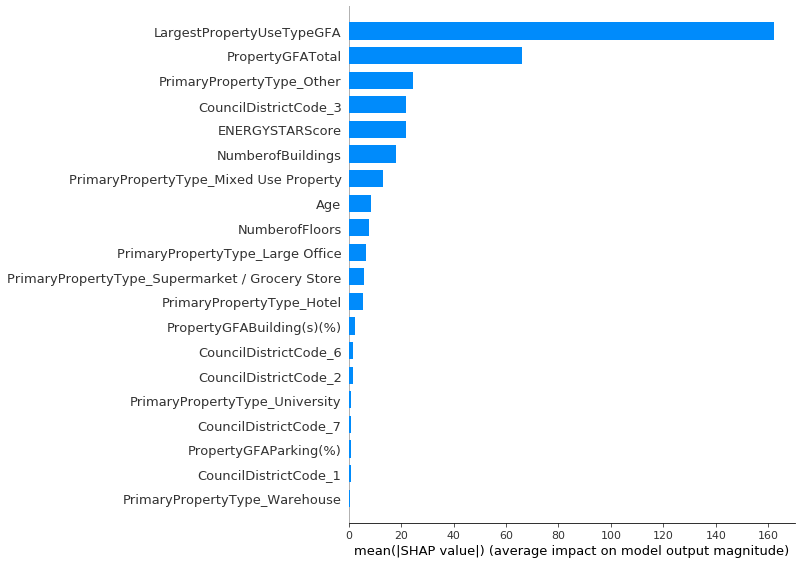

In [215]:
explainer = shap.TreeExplainer(rf, X_train)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test, plot_type="bar")

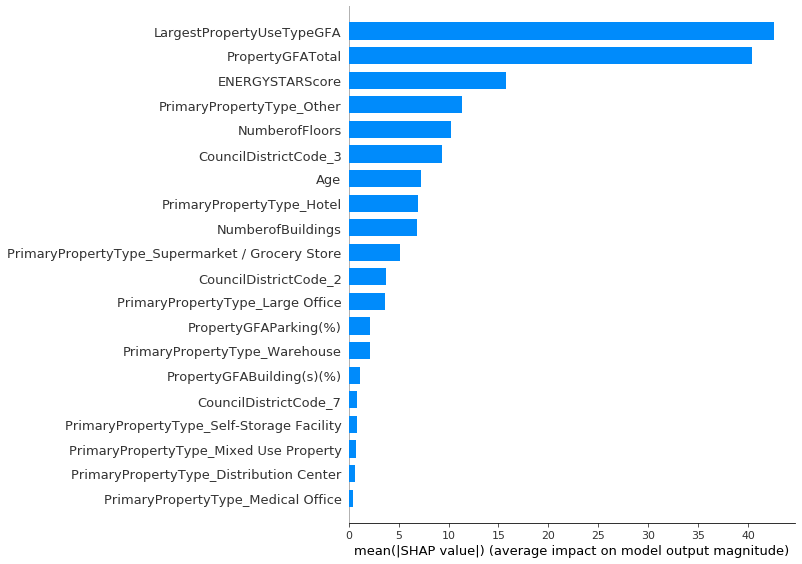

In [226]:
explainer = shap.TreeExplainer(gb, X_train)
shap_values = explainer.shap_values(X_test_tt, check_additivity=False)
shap.summary_plot(shap_values, X_test_tt, plot_type="bar")

In [461]:
#print feature importance with names
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': gb.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
3,PropertyGFATotal,0.418371
6,LargestPropertyUseTypeGFA,0.178565
7,ENERGYSTARScore,0.070414
0,Age,0.056471
19,PrimaryPropertyType_Supermarket / Grocery Store,0.047662
2,NumberofFloors,0.044374
15,PrimaryPropertyType_Other,0.029965
10,PrimaryPropertyType_Hotel,0.029907
21,PrimaryPropertyType_Warehouse,0.022279
12,PrimaryPropertyType_Large Office,0.019919


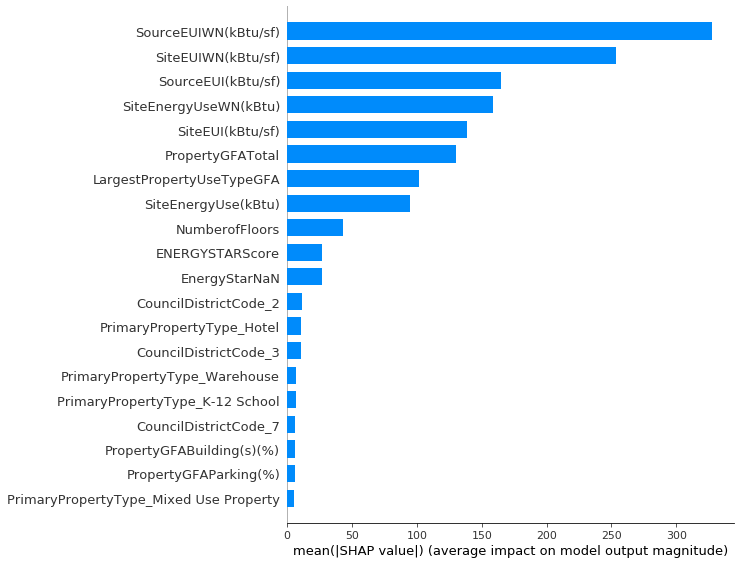

In [311]:
explainer_lr = shap.LinearExplainer(lr, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")

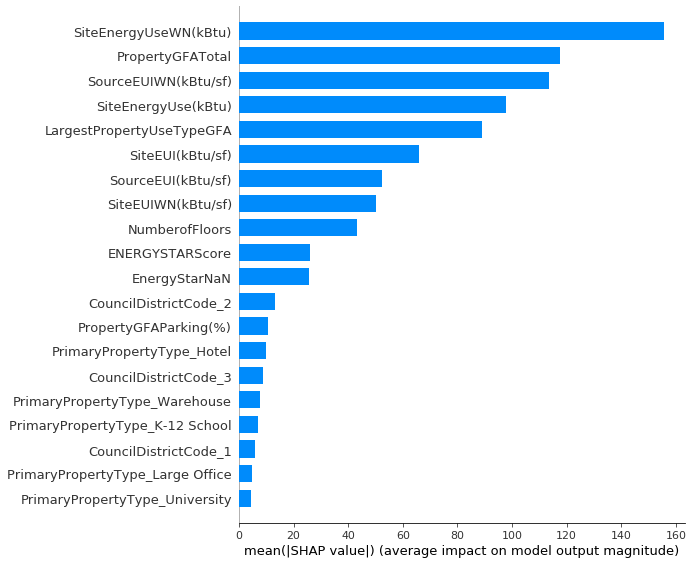

In [309]:
explainer_lasso = shap.LinearExplainer(lasso, X_train)
shap_values_lasso = explainer_lasso.shap_values(X_test)
shap.summary_plot(shap_values_lasso, X_test, plot_type="bar")